<a href="https://colab.research.google.com/github/safakatakancelik/portfolio-public/blob/main/notebooks/customer_segmentation_dea112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation and Targeted Marketing Strategy

---

Objective:
Develop a customer segmentation model to categorize customers into distinct groups based on their purchasing behavior and personal characteristics. Use this model to
recommend targeted marketing strategies for a retail company.

---



Table of contents:
- Import Libraries
- Data Preparation
- EDA
- Data Preprocessing
- Customer Segmentation & Data Visualization
- Insights and Strategy Formulation
- Data Export


### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid") # to ease the interpretation of the visuals

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

### Data Preparation

In [2]:
# Import the dataset and write it to a pandas DataFrame
df = pd.read_csv("https://raw.githubusercontent.com/safakatakancelik/portfolio-public/refs/heads/main/notebooks/data/datasets/Superstore/data_prepared_with_tableau_prep/data_prep/orders_oct27_assigned_unique_productIDs.csv")
df.head()
## This is the Superstore dataset from Tableau, I prepared it with Tableau Prep Builder and finalized it with a jupyter notebook.
## All the data files, preparation projects, the notebook for the final version can be found here:
## https://github.com/safakatakancelik/portfolio-public/tree/main/notebooks/data/datasets/Superstore/
## The README.MD summarizes the cleaning steps

Unnamed: 0 Is Duplicate Row?  Days to Ship                   Table Names  \
0           0            Unique             4            Orders_Central.csv   
1           1            Unique             6            Orders_Central.csv   
2           2            Unique             6            Orders_Central.csv   
3           3            Unique             3  Orders_East.xlsx/Orders_East   
4           4            Unique             2               Orders_West.csv   

  File Paths         Category          City        Country Customer ID  \
0        NaN        Furniture       Houston  United States    SF-20965   
1        NaN        Furniture  Lincoln Park  United States    DM-12955   
2        NaN  Office Supplies         Tulsa  United States    RB-19465   
3        NaN  Office Supplies  Philadelphia  United States    ON-18715   
4        NaN  Office Supplies      Pasadena  United States    JF-15355   

     Customer Name  ...                                       Product Name  \
0  Sylvia Foulston  ...    Howard Miller Distant Time Traveler Alarm Clock   
1     Dario Medina  ...            O'Sullivan 2-Shelf Heavy-Duty Bookcases   
2     Rick Bensley  ...  Avery Recycled Flexi-View Covers for Binding S...   
3    Odella Nelson  ...                                         Newell 320   
4         Jay Fein  ...                         GBC Durable Plastic Covers   

  Return Reason  Returned?  Return Notes  Return Approver Quota-2015  \
0           NaN         No           NaN              NaN     100000   
1           NaN         No           NaN              NaN     100000   
2           NaN         No           NaN              NaN     100000   
3           NaN         No           NaN              NaN     125000   
4           NaN         No           NaN              NaN     115000   

   Quota-2016 Quota-2017 Quota-2018 Unique Product ID  
0      105000     120000     145000               263  
1      105000     120000     145000                 3  
2      105000     120000     145000               665  
3      150000     175000     200000               499  
4      200000     225000     300000               789  

[5 rows x 34 columns]

#### Preparing a Customers DataFrame + Feature Engineering with RFM Metrics
---
Because the Superstore dataset is at the order level, and this analysis aims to segment customers, I prepare a new dataframe aggregated at the customer level with new features

In [3]:
# Checked all the columns to identify columns that are in the interest of this segmentation
df.columns

Index(['Unnamed: 0', 'Is Duplicate Row?', 'Days to Ship', 'Table Names',
       'File Paths', 'Category', 'City', 'Country', 'Customer ID',
       'Customer Name', 'Order Date', 'Order ID', 'Postal Code', 'Profit',
       'Quantity', 'Region', 'Row ID', 'Segment', 'Ship Date', 'Ship Mode',
       'State', 'Sub-Category', 'Sales', 'Discount', 'Product Name',
       'Return Reason', 'Returned?', 'Return Notes', 'Return Approver',
       'Quota-2015', 'Quota-2016', 'Quota-2017', 'Quota-2018',
       'Unique Product ID'],
      dtype='object')

In [4]:
# I chose these columns to keep and use with the features I will be engineering.
columns_interested = [
'Customer ID', 'Sales', "Quantity", "Profit",
"Region", 'Segment', 'Category', 'Sub-Category',
'Unique Product ID', "Row ID",
'Order ID', 'Order Date'
]

In [5]:
# Created a copy of the dataframe to work cleaner.
df_temporary = df[columns_interested].copy()
df_temporary.head()
## I called it df_temporary; I will work on this dataframe to build the features and the dataframe at the customer level.
## Then I will assign that final dataframe to a new variable to use it in the later stages.

Customer ID    Sales  Quantity   Profit   Region      Segment  \
0    SF-20965   21.936         2 -10.4196  Central    Corporate   
1    DM-12955  194.320         4  31.0912  Central    Corporate   
2    RB-19465   32.060         2  15.3888  Central  Home Office   
3    ON-18715    6.840         2   0.5992     East    Corporate   
4    JF-15355   92.880         6  30.1860     West     Consumer   

          Category Sub-Category  Unique Product ID  Row ID        Order ID  \
0        Furniture  Furnishings                263    1675  CA-2016-143077   
1        Furniture    Bookcases                  3    3031  CA-2016-168480   
2  Office Supplies      Binders                665    5980  CA-2015-117765   
3  Office Supplies          Art                499    1472  US-2016-161466   
4  Office Supplies      Binders                789    7242  CA-2018-136651   

              Order Date  
0  9/17/2016 12:00:00 AM  
1  9/21/2016 12:00:00 AM  
2   9/7/2015 12:00:00 AM  
3  9/24/2016 12:00:00 AM  
4  4/23/2018 12:00:00 AM

In [6]:
# Overviewing the dataframe
df_temporary.info()
## It is still on the order level, however, it only has the columns of interest.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9952 entries, 0 to 9951
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer ID        9952 non-null   object 
 1   Sales              9952 non-null   float64
 2   Quantity           9952 non-null   int64  
 3   Profit             9952 non-null   float64
 4   Region             9952 non-null   object 
 5   Segment            9952 non-null   object 
 6   Category           9952 non-null   object 
 7   Sub-Category       9952 non-null   object 
 8   Unique Product ID  9952 non-null   int64  
 9   Row ID             9952 non-null   int64  
 10  Order ID           9952 non-null   object 
 11  Order Date         9952 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 933.1+ KB


In [7]:
# Type Cast Order Date to date for cleaner operations
df_temporary['Order Date'] = pd.to_datetime(df_temporary['Order Date'], format="%m/%d/%Y %I:%M:%S %p").dt.floor('D')


For the segmentation my approach was RFM Analysis. For this I calculated Recency, Frequency and Monetary (RFM) metrics, along with additional metrics.


In [8]:
# RECENCY METRICS

# Calculated store level first and latest order dates for the rest of the calculations.
latest_order_date = df_temporary['Order Date'].max() #treated as today's date
first_order_date = df_temporary['Order Date'].min()

# Customer level first and last order dates
df_temporary['First Order Date (day)'] = df_temporary.groupby('Customer ID')['Order Date'].transform('min')
df_temporary['First Order Date (month)'] = df_temporary['First Order Date (day)'].dt.to_period('M')
df_temporary['Last Order Date (day)'] = df_temporary.groupby('Customer ID')['Order Date'].transform('max')
df_temporary['Last Order Date (month)'] = df_temporary['Last Order Date (day)'].dt.to_period('M')

# Customer Churn Feature
## Churn definition: if a customer's last order is not within the last 6 months they're considered churned.
## Latest order date in the dataset has been treated as the today's date.
df_temporary['Days Since Last Order'] = (latest_order_date - df_temporary['Last Order Date (day)']).dt.days
df_temporary['Churned'] = df_temporary['Days Since Last Order'] > 180

# Customer lifetime in the units of months and days
df_temporary['Customer Lifetime (months)'] = (df_temporary['Last Order Date (month)'] - df_temporary['First Order Date (month)']).apply(lambda x: x.n) + 1
df_temporary['Customer Lifetime (days)'] = (df_temporary['Last Order Date (day)'] - df_temporary['First Order Date (day)']).dt.days

In [9]:
# FREQUENCY METRICS

# Total amount of orders, unique products and quantity of products ordered by each customer.
df_temporary['Total Orders'] = df_temporary.groupby('Customer ID')['Order ID'].transform('nunique')
df_temporary['Total Products'] = df_temporary.groupby('Customer ID')['Unique Product ID'].transform('nunique')
df_temporary['Total Quantity'] = df_temporary.groupby('Customer ID')['Quantity'].transform('sum')

# Purchase frequency of each customer
# Average number of orders per month throughout a customer's lifetime.
df_temporary['Purchase Frequency'] = df_temporary['Total Orders'] / df_temporary['Customer Lifetime (months)']

In [10]:
# MONETARY METRICS

# Total sales, profits and profit margin from a customer
df_temporary['Total Sales'] = df_temporary.groupby('Customer ID')['Sales'].transform('sum')
df_temporary['Total Profit'] = df_temporary.groupby('Customer ID')['Profit'].transform('sum')
df_temporary['Profit Margin'] = df_temporary['Total Profit'] / df_temporary['Total Sales']

# Average order value of a customer
df_temporary['Avg Order Value'] = df_temporary['Total Sales'] / df_temporary['Total Orders']

Here I finalize the customer dataframe.

In [11]:
# The new dataframe will only contain these calculated metrics.
customer_level_interested_columns = [ "Customer ID",
        'First Order Date (day)', 'First Order Date (month)',
       'Last Order Date (day)', 'Last Order Date (month)',
       'Days Since Last Order', 'Churned',
       'Customer Lifetime (months)', 'Customer Lifetime (days)',
       'Total Orders', 'Total Products', 'Total Quantity',
       'Purchase Frequency', 'Total Sales', 'Total Profit', 'Profit Margin', 'Avg Order Value',
]


customer_df = df_temporary[customer_level_interested_columns].drop_duplicates()
customer_df.info()
# Now we have a customer level dataframe with chosen metrics.

<class 'pandas.core.frame.DataFrame'>
Index: 793 entries, 0 to 9868
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Customer ID                 793 non-null    object        
 1   First Order Date (day)      793 non-null    datetime64[ns]
 2   First Order Date (month)    793 non-null    period[M]     
 3   Last Order Date (day)       793 non-null    datetime64[ns]
 4   Last Order Date (month)     793 non-null    period[M]     
 5   Days Since Last Order       793 non-null    int64         
 6   Churned                     793 non-null    bool          
 7   Customer Lifetime (months)  793 non-null    int64         
 8   Customer Lifetime (days)    793 non-null    int64         
 9   Total Orders                793 non-null    int64         
 10  Total Products              793 non-null    int64         
 11  Total Quantity              793 non-null    int64         
 12

In [12]:
# Filtering out customers who made their first order within the last 180 days.
customer_df = customer_df[customer_df['First Order Date (day)'] < (latest_order_date - pd.to_timedelta(180, unit='days'))]
## This is to have a more reliable churn analysis.
## Based on our definition anyone who has joined within the last 180 days cannot be considered churned, and this can help to improve the quality of our sample.

In [13]:
# Final overview look at the prepared dataframe.
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 787 entries, 0 to 9868
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Customer ID                 787 non-null    object        
 1   First Order Date (day)      787 non-null    datetime64[ns]
 2   First Order Date (month)    787 non-null    period[M]     
 3   Last Order Date (day)       787 non-null    datetime64[ns]
 4   Last Order Date (month)     787 non-null    period[M]     
 5   Days Since Last Order       787 non-null    int64         
 6   Churned                     787 non-null    bool          
 7   Customer Lifetime (months)  787 non-null    int64         
 8   Customer Lifetime (days)    787 non-null    int64         
 9   Total Orders                787 non-null    int64         
 10  Total Products              787 non-null    int64         
 11  Total Quantity              787 non-null    int64         
 12

### EDA

In [14]:
customer_df.shape

(787, 17)

In [15]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 787 entries, 0 to 9868
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Customer ID                 787 non-null    object        
 1   First Order Date (day)      787 non-null    datetime64[ns]
 2   First Order Date (month)    787 non-null    period[M]     
 3   Last Order Date (day)       787 non-null    datetime64[ns]
 4   Last Order Date (month)     787 non-null    period[M]     
 5   Days Since Last Order       787 non-null    int64         
 6   Churned                     787 non-null    bool          
 7   Customer Lifetime (months)  787 non-null    int64         
 8   Customer Lifetime (days)    787 non-null    int64         
 9   Total Orders                787 non-null    int64         
 10  Total Products              787 non-null    int64         
 11  Total Quantity              787 non-null    int64         
 12

In [16]:
# Looking at descriptive statistics
customer_df.describe()
## By comparing 3rd quartiles and max values I can see there are significant outliers on upper tails of each feature except customer lifetimes
## Total sales, profits have significant outliers in the lower tails. There are customers that we do not profit well of.
## The rest considering their standard deviations and ratios seem reasonable, however, this is just a glance at descriptive statistics.
### I analyze further and focus on few features to have a meaningful clustering.

First Order Date (day)          Last Order Date (day)  \
count                            787                            787   
mean   2015-11-01 19:16:23.481575680  2018-08-04 17:28:26.226175232   
min              2015-01-03 00:00:00            2015-10-22 00:00:00   
25%              2015-05-11 00:00:00            2018-06-30 00:00:00   
50%              2015-09-09 00:00:00            2018-10-15 00:00:00   
75%              2015-12-29 12:00:00            2018-11-30 00:00:00   
max              2018-06-15 00:00:00            2018-12-30 00:00:00   
std                              NaN                            NaN   

       Days Since Last Order  Customer Lifetime (months)  \
count             787.000000                  787.000000   
mean              147.271919                   34.062262   
min                 0.000000                    1.000000   
25%                30.000000                   28.000000   
50%                76.000000                   37.000000   
75%               183.000000                   41.000000   
max              1165.000000                   48.000000   
std               186.683850                    9.840066   

       Customer Lifetime (days)  Total Orders  Total Products  Total Quantity  \
count                787.000000    787.000000      787.000000      787.000000   
mean                1006.925032      6.346887       12.546379       47.811944   
min                    0.000000      1.000000        1.000000        2.000000   
25%                  842.500000      5.000000        8.000000       30.000000   
50%                 1093.000000      6.000000       12.000000       44.000000   
75%                 1222.500000      8.000000       16.000000       63.000000   
max                 1440.000000     17.000000       36.000000      150.000000   
std                  299.193459      2.520728        6.134524       24.678136   

       Purchase Frequency   Total Sales  Total Profit  Profit Margin  \
count          787.000000    787.000000    787.000000     787.000000   
mean             0.205660   2907.186488    359.684021       0.105850   
min              0.046512      4.833000  -6626.389500      -2.372297   
25%              0.139535   1164.225000     35.271950       0.040133   
50%              0.184211   2258.180000    226.452900       0.142833   
75%              0.238095   3787.491400    561.391950       0.222999   
max              2.000000  25043.016000   8981.323900       0.471406   
std              0.131477   2631.148183    896.508999       0.210538   

       Avg Order Value  
count       787.000000  
mean        457.267112  
min           2.416500  
25%         210.604103  
50%         360.829200  
75%         544.534143  
max        5008.603200  
std         433.254632

In [17]:
# I excluded customer ID, first order and last order dates
numerical_cols_of_interest = ['Days Since Last Order',
       'Customer Lifetime (months)', 'Customer Lifetime (days)',
       'Total Orders', 'Total Products', 'Total Quantity',
       'Purchase Frequency', 'Total Sales', 'Total Profit', 'Avg Order Value',
       'Profit Margin', 'Churned']

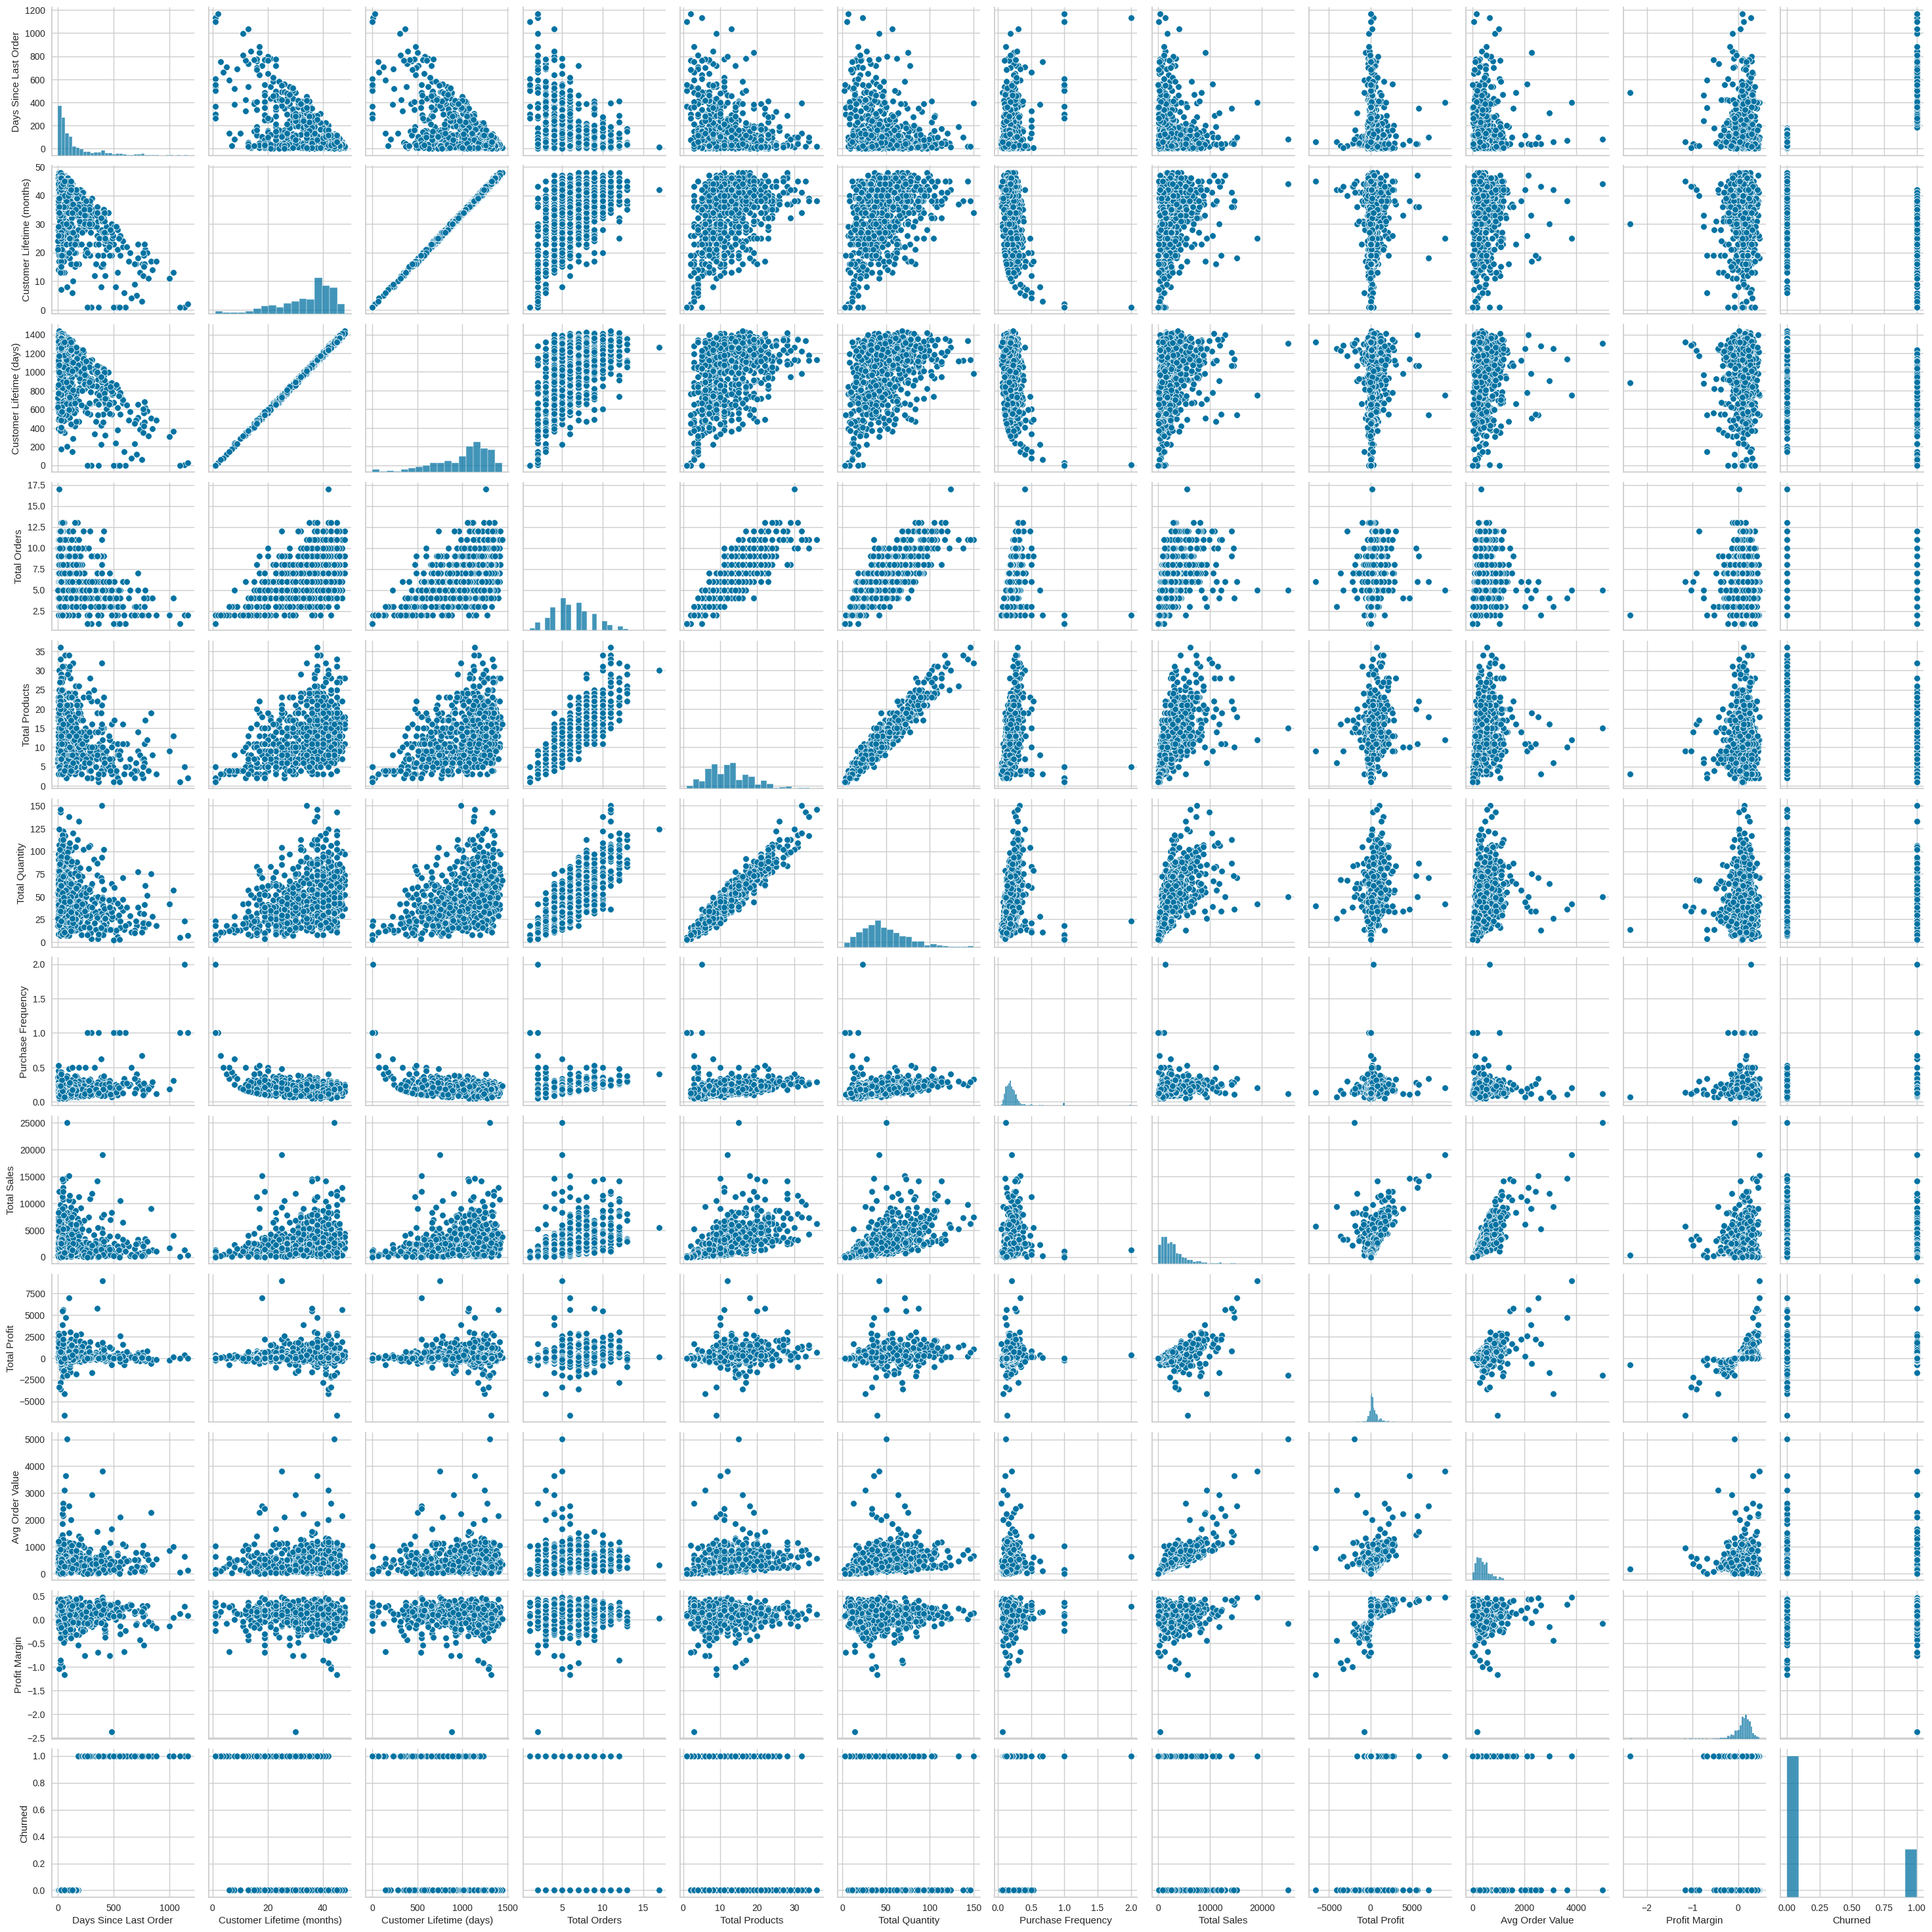

In [18]:
# Plotted pairwise relations and distributions
sns.pairplot(data=customer_df[numerical_cols_of_interest])

distribution check notes:
- total sales right skewed, but profits seem normal overall
- total unique product and total ordered quantity seems normally distributed with some potential outliers on upper tail
- profits are normal and have a strong peak around the mean area
- profit margins are positive overall, but there seems to be significant outliers on the lower tail. As noticed earlier the negative pattern here at sales-profits-profit margins is not favorable, and can be investigated further.

scatterplots
- profit margin - total profit: there seems a clear breakpoint we can analyze.
- avg order - customer lifetime: could be a positive correlation
- avg order value - sales: there appears a strong positive correlation. Not unusual, yet a significant positive indicator for the business.
- purchase freqency - customer life time: couldn't notice significances, yet the pattern looked interesting.

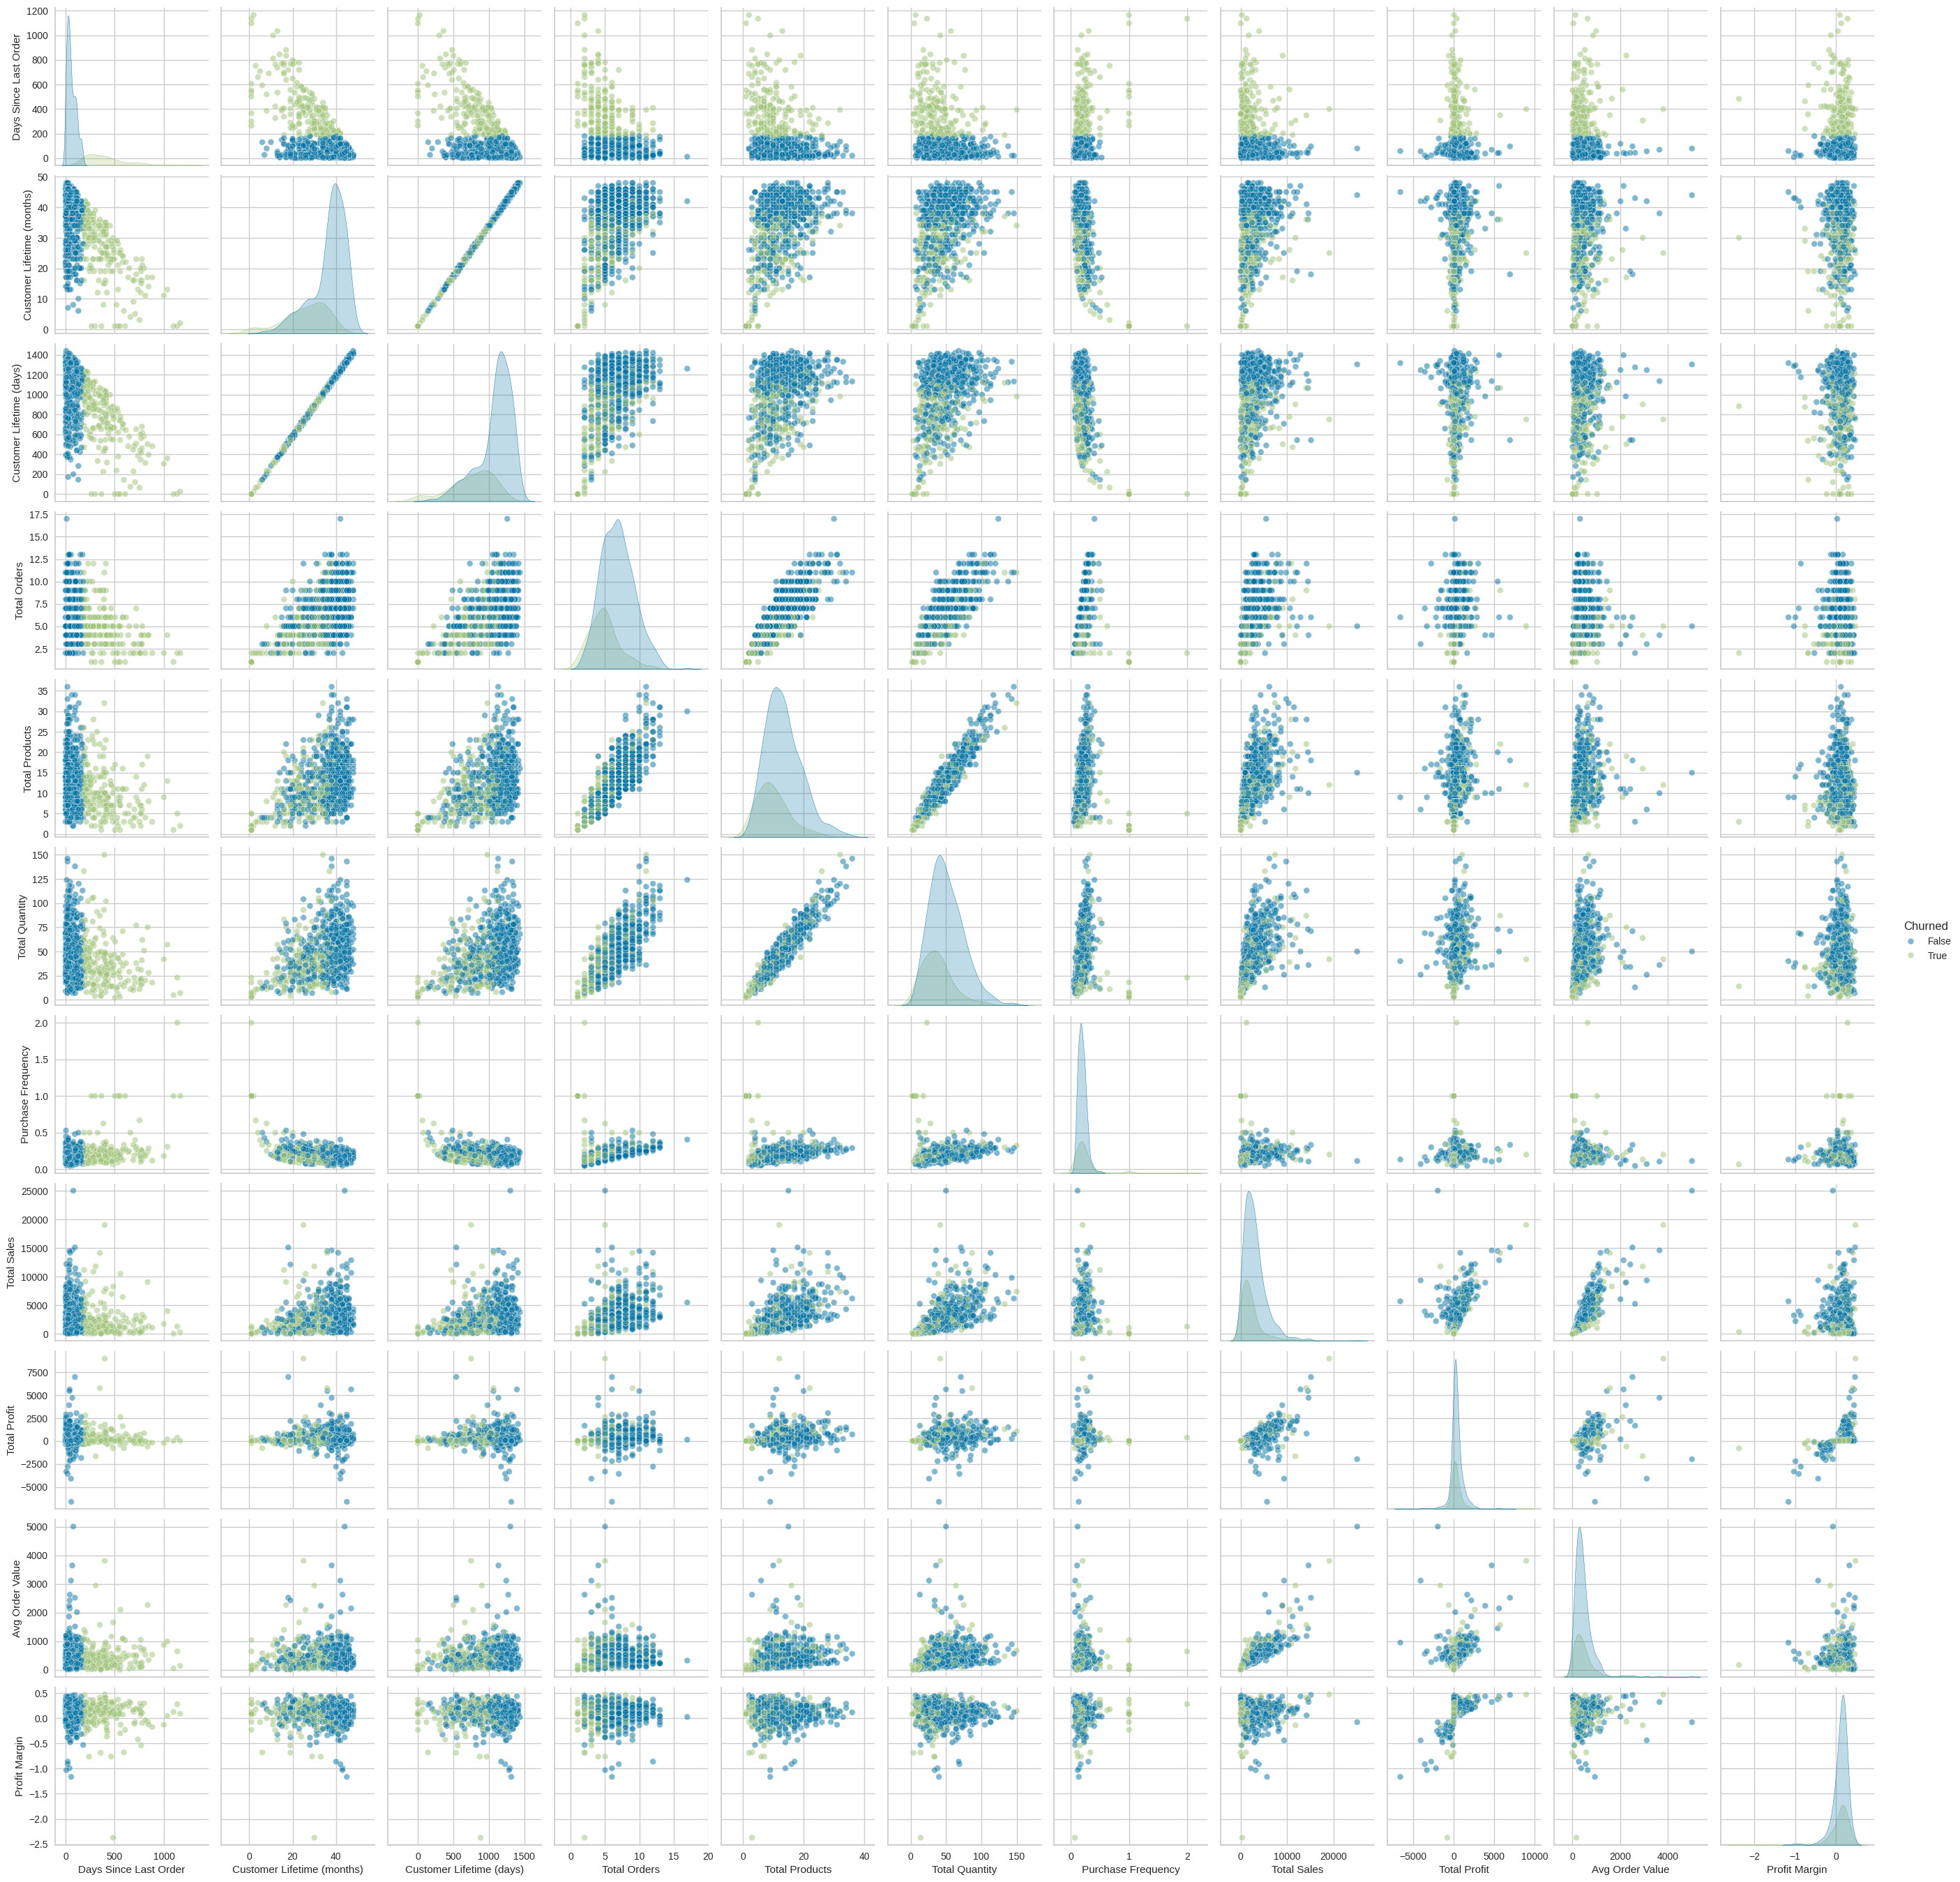

In [19]:
# Plotted the pairplot again, this time with the hue Churned
sns.pairplot(data=customer_df[['Days Since Last Order',
       'Customer Lifetime (months)', 'Customer Lifetime (days)',
       'Total Orders', 'Total Products', 'Total Quantity',
       'Purchase Frequency', 'Total Sales', 'Total Profit', 'Avg Order Value',
       'Profit Margin', 'Churned']],
        hue="Churned",
        plot_kws={'alpha': 0.5, 's': 40})

- I couldn't see significantly different patterns with this hue.
- However, I got suspicious of the distribution of churned customers within the Purchase Frequency - Customer Lifetime scatterplots.

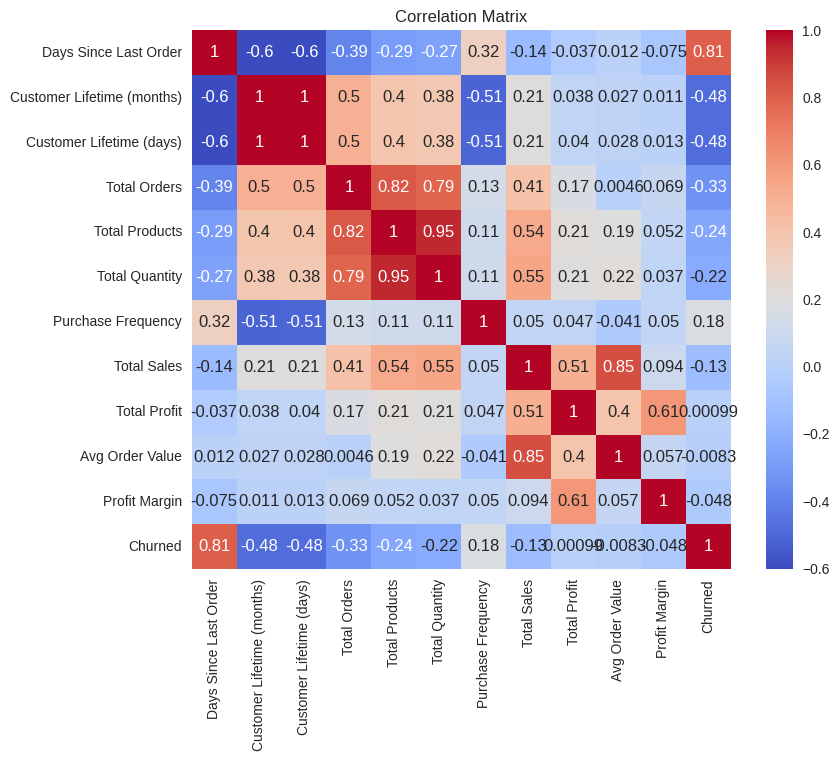

In [20]:
# CORRELATION MATRIX
correlation_matrix = customer_df[numerical_cols_of_interest].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, square=True, cmap="coolwarm", )
plt.title("Correlation Matrix")
plt.show()

After analyzing the correlations these two stood out to me:
Avg Order Value - Total Sales: 0.85
- This is favorable relation for the business.

Purchase Freq - Customer Lifetime (days): - 0.51
- Although not it's not a strong correlation, this number made me more curious about the earlier pattern I got suspicious. Additionally, I think clustering for pairs that do not have significant correlations can help discover new patterns we don't know of.

Because of these I isolated these two pairs.

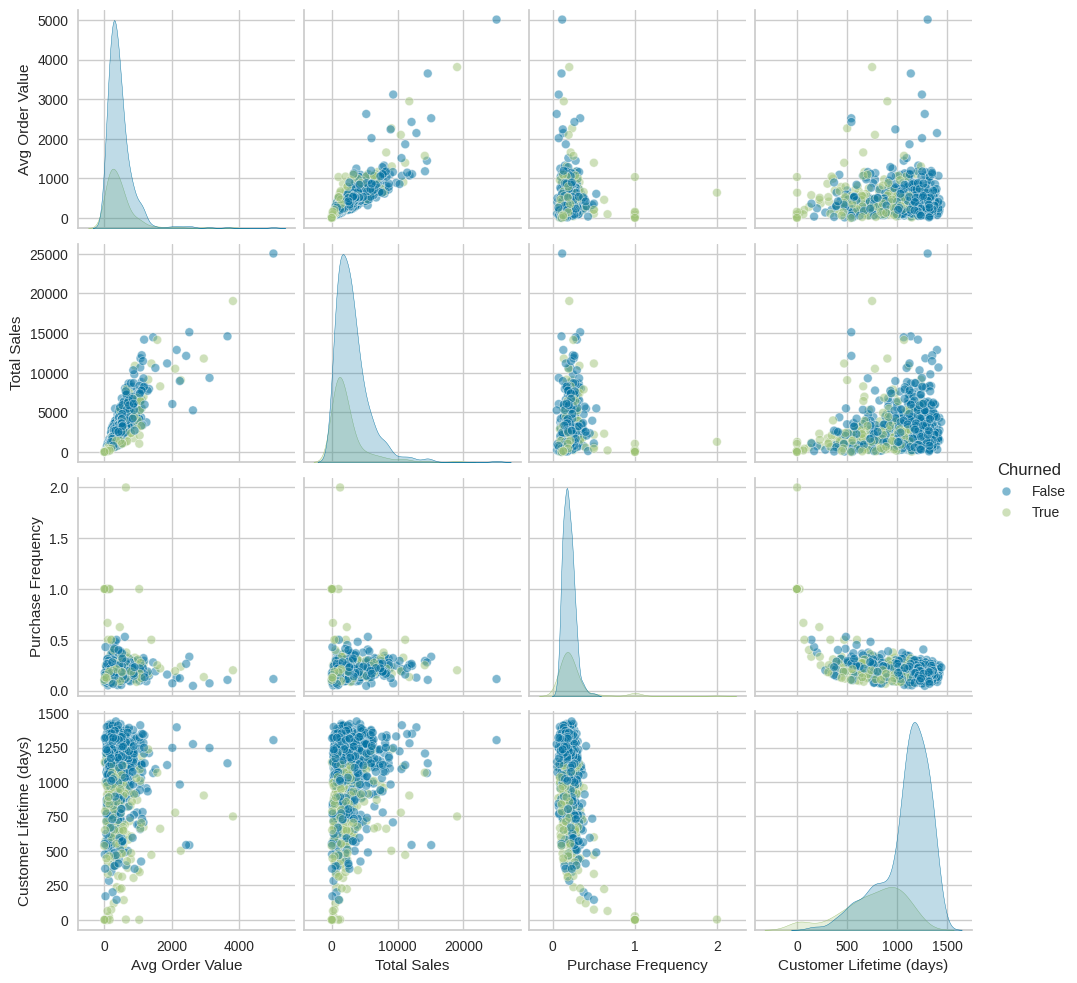

In [21]:
# Plotting again with only selected features to see more clearly.
sns.pairplot(customer_df[['Avg Order Value', 'Total Sales', "Purchase Frequency", "Customer Lifetime (days)", "Churned"]],  hue="Churned", plot_kws={'alpha': 0.5, 's': 40})

In this section, I got more suspicious of the pattern I noticed at purchase frequency and customer lifetime (days) pairs. Overall the pattern seems consistent across different pairs that contain Customer Lifetime. The data suggests that the churned customer amounts are decreasing as the customer lifetime is increasing. Although the pattern is not exceptional, this lead to reasonable clustering and actionable insights for the business.

---

During my analysis, I checked various dimensions, and conducted clustering for different pairs, identified and looked at other patterns, however, this analysis prioritized the Purchase Frequency - Customer Lifetime (days) pair.

### Data Preprocessing

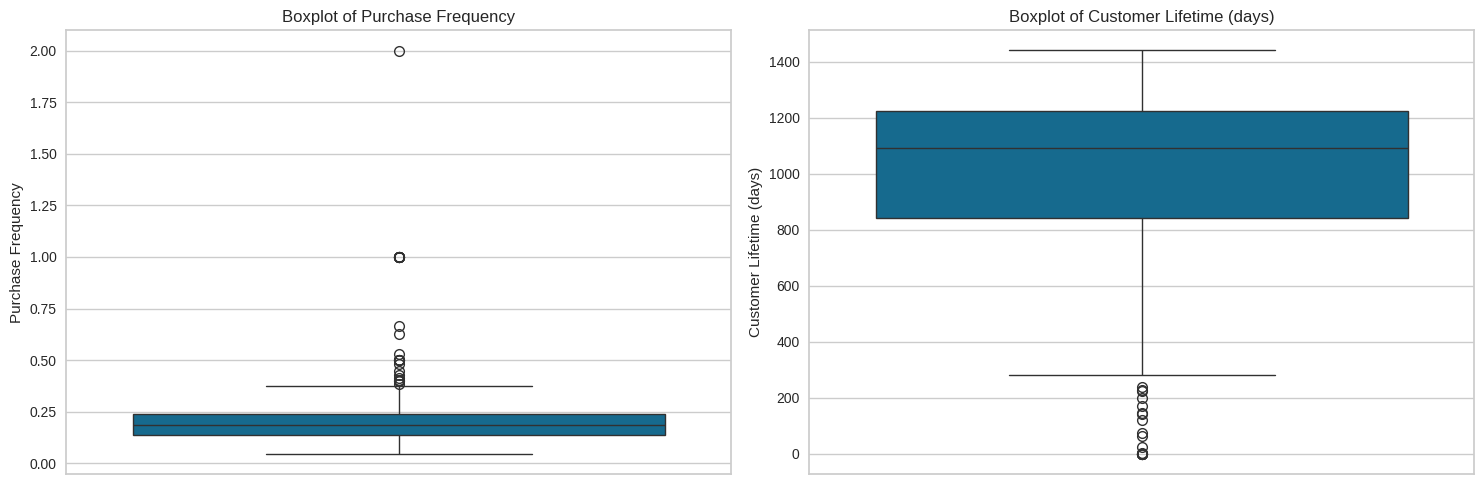

In [22]:
# Boxplot to check outliers
cols_to_boxplot = ["Purchase Frequency", "Customer Lifetime (days)"]

plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_to_boxplot):
    plt.subplot(1, len(cols_to_boxplot), i + 1)
    sns.boxplot(y=customer_df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

In [23]:
# Outlier removal for Purchase Frequency
cols_to_filter = ["Purchase Frequency"]
mean = customer_df["Purchase Frequency"].mean()
std = customer_df["Purchase Frequency"].std()
customer_df = customer_df[(customer_df["Purchase Frequency"] > mean - 3 * std) & (customer_df["Purchase Frequency"] < mean + 3 * std)].copy()
## I removed outliers with 3 standard deviations around the mean because the distribution is normal

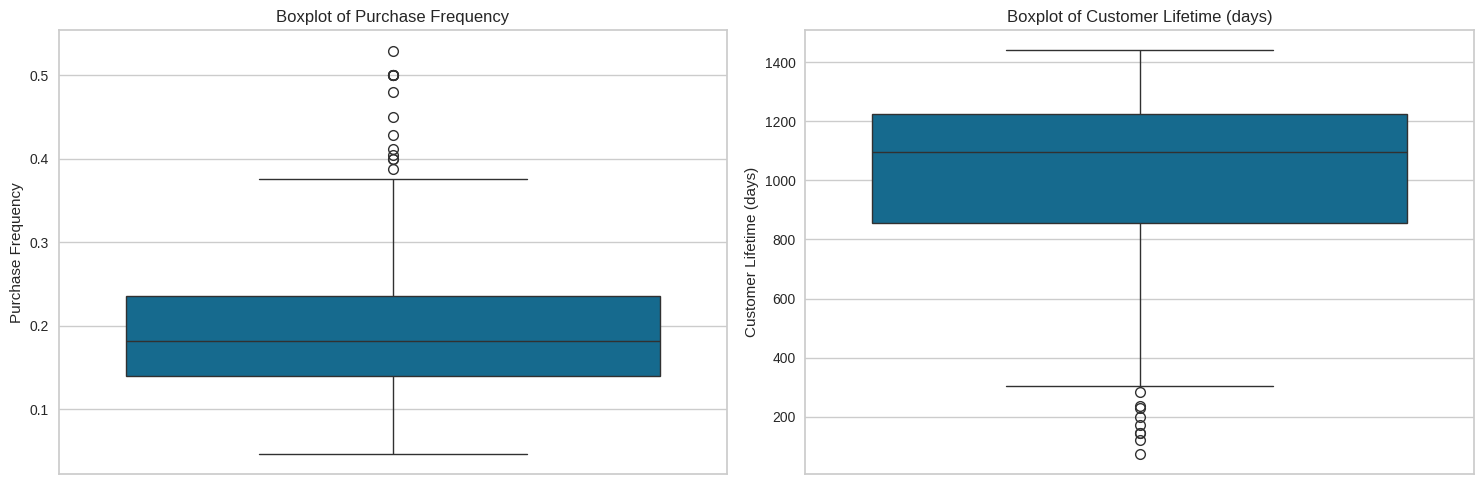

In [24]:
# Checked the boxplots again
cols_to_boxplot = ["Purchase Frequency", "Customer Lifetime (days)"]

plt.figure(figsize=(15, 5))
for i, col in enumerate(cols_to_boxplot):
    plt.subplot(1, len(cols_to_boxplot), i + 1)
    sns.boxplot(y=customer_df[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

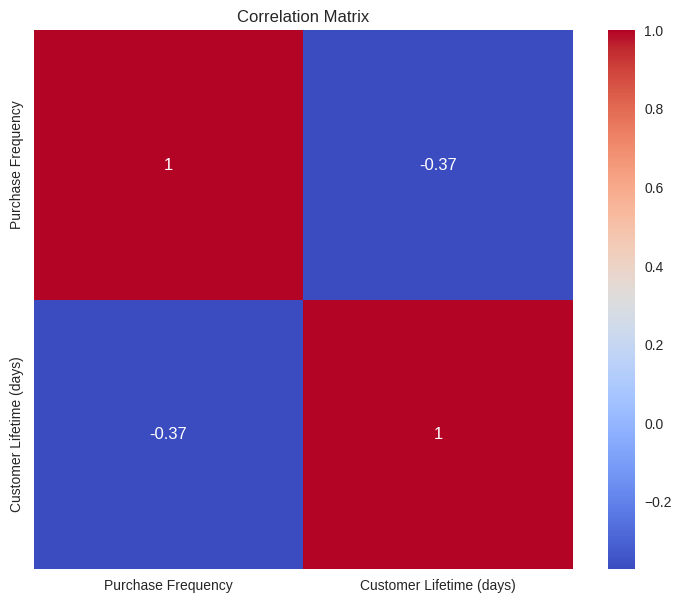

In [25]:
# CORRELATION MATRIX
correlation_matrix = customer_df[["Purchase Frequency", "Customer Lifetime (days)"]].corr()

plt.figure(figsize=(9, 7)) # Increased figure size
sns.heatmap(correlation_matrix, annot=True, square=True, cmap="coolwarm", )
plt.title("Correlation Matrix")
plt.show()
# After the outlier removal the negative correlation decreased, yet this is not a concern for the clustering I'm running.

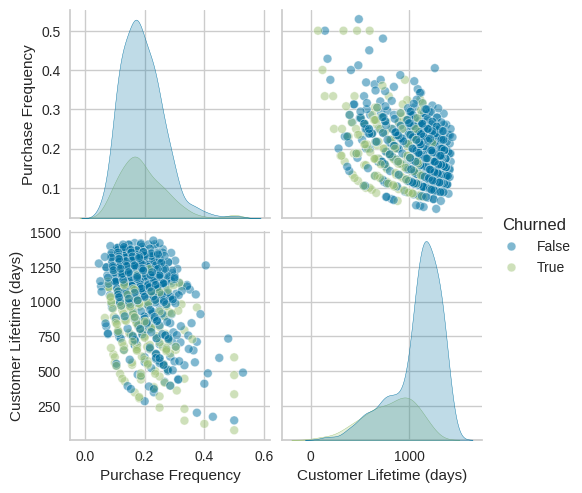

In [26]:
# Pair plot after outlier removal
sns.pairplot(customer_df[["Purchase Frequency", "Customer Lifetime (days)", "Churned"]],  hue="Churned", plot_kws={'alpha': 0.5, 's': 40})

#### Log Transform

In [27]:
# Log transform Customer Lifetime (days)
customer_df['Customer Lifetime (days)_log'] = np.log(customer_df['Customer Lifetime (days)'] + 1) # +1 is added constant for 0 values, but no zero in this case, still kept.
# to decrease the values in the lower tail's impact in the skewed distribution
# Didn't transform Purchase Frequency because it's already a ratio and normal

#### Selection

In [28]:
# Selected/isolated features to be used in the clustering
X_features_purchasefreq_lifetime = customer_df[['Customer Lifetime (days)_log', "Purchase Frequency"]]

#### Scaling

In [29]:
# Scaled the features with a standard scaler
scaler = StandardScaler()
X_features_purchasefreq_lifetime_scaled = scaler.fit_transform(X_features_purchasefreq_lifetime)

### Customer Segmentation & Data Visualization

#### Elbow Method for Optimal K value selection

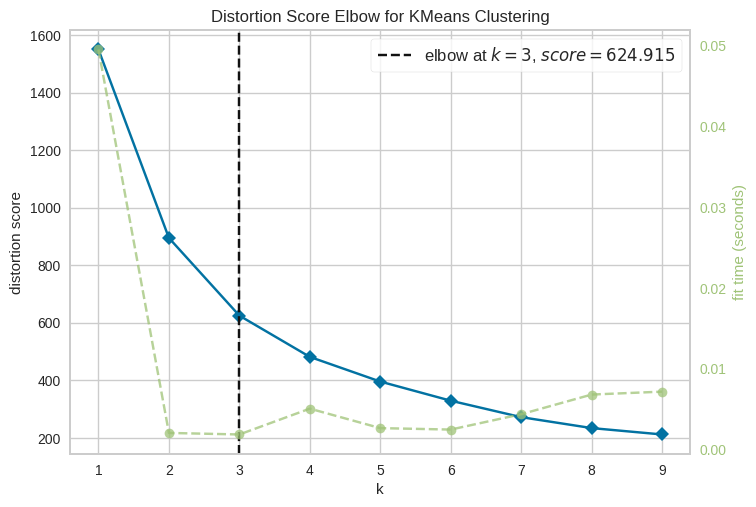

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
# Used an elbow method to choose an optimum k value

kmeans_elbow = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans_elbow, k=(1, 10))
visualizer.fit(X_features_purchasefreq_lifetime_scaled)
visualizer.show()
# The KElbowVisualizer from Yellow Brick suggested 3 as the optimum k, I tried 3 and 5, and chose to use 3.

#### K-Means Clustering and Visualization

In [31]:
# K-Means Clustering

#Model Build
kmeans_purchasefreq_lifetime = KMeans(n_clusters= 3, init='k-means++', random_state=42)

# Clustering
y_kmeans_purchasefreq_lifetime= kmeans_purchasefreq_lifetime.fit_predict(X_features_purchasefreq_lifetime_scaled)

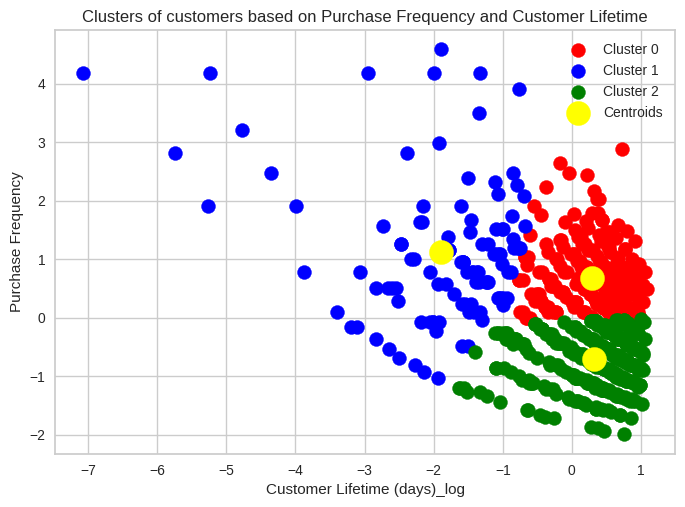

In [32]:
#Visualizing all the clusters
plt.scatter(X_features_purchasefreq_lifetime_scaled[y_kmeans_purchasefreq_lifetime == 0, 0], X_features_purchasefreq_lifetime_scaled[y_kmeans_purchasefreq_lifetime == 0, 1], s = 100, c = 'red', label = 'Cluster 0')
plt.scatter(X_features_purchasefreq_lifetime_scaled[y_kmeans_purchasefreq_lifetime == 1, 0], X_features_purchasefreq_lifetime_scaled[y_kmeans_purchasefreq_lifetime == 1, 1], s = 100, c = 'blue', label = 'Cluster 1')
plt.scatter(X_features_purchasefreq_lifetime_scaled[y_kmeans_purchasefreq_lifetime == 2, 0], X_features_purchasefreq_lifetime_scaled[y_kmeans_purchasefreq_lifetime == 2, 1], s = 100, c = 'green', label = 'Cluster 2')

plt.scatter(kmeans_purchasefreq_lifetime.cluster_centers_[:, 0], kmeans_purchasefreq_lifetime.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers based on Purchase Frequency and Customer Lifetime') # Corrected title
plt.xlabel('Customer Lifetime (days)_log')
plt.ylabel('Purchase Frequency')
plt.legend()
plt.show()

Here appears 3 distinct clusters.

    Cluster 0 - Long Tenure, Above Average Purchase Frequency
    Cluster 1 - Short Tenure, Variant Purchase Frequency
    Cluster 2 - Long Tenure, Below Average Purchase Frequency

In [33]:
# Assigning cluster labels back to the customer dataframe
customer_df['Cluster(Freq-Lifetime)'] = y_kmeans_purchasefreq_lifetime

# Map numerical cluster labels to descriptive strings
cluster_label_map_freq_lifetime = {
    0: "Cluster 0 - Long Tenure, Above Avg Freq",
    1: "Cluster 1 - Short Tenure, Variant Freq",
    2: "Cluster 2 - Long Tenure, Below Avg Freq)"
}

customer_df['Cluster(Freq-Lifetime)'] = customer_df['Cluster(Freq-Lifetime)'].map(cluster_label_map_freq_lifetime)

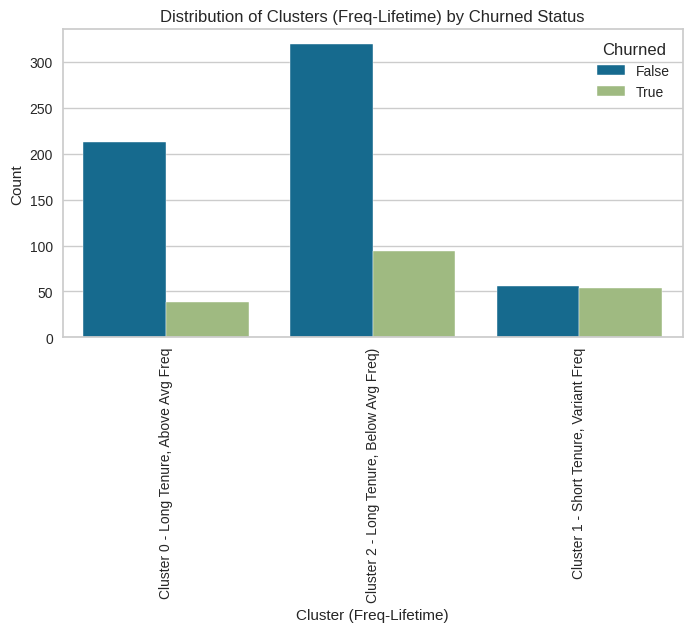

In [34]:
# Plotting a bar chart with the hue of churned to see the distribution of this dimension across these clusters.
plt.figure(figsize=(8, 4))
sns.countplot(data=customer_df, x='Cluster(Freq-Lifetime)', hue='Churned')
plt.title('Distribution of Clusters (Freq-Lifetime) by Churned Status')
plt.xlabel('Cluster (Freq-Lifetime)')
plt.ylabel('Count')
plt.xticks(rotation=90) # Rotate x-axis labels
plt.show()

In [35]:
# Generating descriptive statistics to help with the insights
customer_df[["Purchase Frequency", 'Customer Lifetime (days)']].describe()

Purchase Frequency  Customer Lifetime (days)
count          775.000000                775.000000
mean             0.192984               1022.109677
std              0.073449                275.142748
min              0.046512                 74.000000
25%              0.139212                855.500000
50%              0.181818               1097.000000
75%              0.235294               1224.000000
max              0.529412               1440.000000

---


### Insights and Strategy Formulation

- Customers with long tenure have significantly lower churned rates.
- Customers with long tenure have more consistent purchase frequencies.
- Customers with short tenure have a wider spread of purchase frequencies.
- Our new customers follow more variant purchase patterns, however, over time (approximately 2 year/747 days/mean-1std) they fit into one of these long tenure clusters.
- Clusters with long tenure Cluster 0 and Cluster 1, differentiate clearly around average purchase frequency 0.192
- Cluster 0 (long tenure, above average purchase frequency) should be our most desirable cluster of customers.

---

- Using these clusters we can shape our marketing efforts and personalize them further. We can start with targeting a sample of customers, and if over time we see increase in gains and alignment with the goals, we can use these patterns to predict the future behaviour of our customers, apply these efforts to more customers.
- Cluster 1 should be seen as new customers that are building their relationships with us. We can tolerate less profitable sales here, can offer more discounts and campaigns to build loyalty.
- Cluster 2 can be seen as a negative example of a loyal customer. If there are customers with negative profitability, we should consider shaping our efforts, and try to influence these customers to the behaviours of Cluster 0.
- Cluster 0 our loyal and frequently buying customers. We can try to survey them to understand what they like and dislike further to improve our efforts overall. Additionally, without disturbing them we can try to increase their purchase frequency as well.

### Data Export

In [36]:
# # Writing a csv file for the dashboard
# customer_df.to_csv("customer_df.csv")

In [37]:
# customer_df.info()